# Tutorial 1: Risk and Renewable Energy Investments

## Background

The vast majority of energy transition scenarios are based on a significant penetration of renewable energies, and offshore wind in particular. The expansion of these technologies allows to reduce the GHG emissions, but also to the development of a specialised national industry. 

Generally, production costs tend to fall as total installed capacity rises (*learning-by-doing*): there is a long-term benefit to install renewable energies even if there are more costly today. On the other hand, the profitability of investments in this sector is more uncertain. The cost of producing energy using renewable technologies is (for the moment) higher than for traditional technologies, and their intermittency makes it risky to sell electricity on the spot market. 

The more risky a project is, the higher the risk premium that investors will demand. Risk-averse actors, such as smaller firms or citizen cooperatives, might be left out of the market.

We distinguish three main dimensions of risk and uncertainty:
1. Macroeconomic environment (uncertain long-term spot price)
2. Daily meteorological environment (risky daily production)
3. Technological environment (uncertain rate of improvement of technologies - turbines in particular - and the opportunity cost of future investment)

With regard to the first two factors, the introduction of a *feed-in tariff* (i.e. a fixed purchase price) or *feed-in premium* (i.e. a subsidy covering the difference between market prices and production costs) on an annual basis eliminates most of the uncertainty for private project developers. 

With a price fixed in advance, investment in renewable energy becomes essentially risky, rather than uncertain: This type of remuneration generates stochasticity (variation in the annual wind resource), which is now probabilisable. 

## Stimulering Duurzame Energie, SDE ++ 

### Goal

SDE ++ supports all projects that reduce GHG emissions. It is technology specific.

### Main characteristics

- Auction: firms compete on the amount of subsidy they ask (the bid)
- Feed-in premium: the subsidy is the difference between the bid and the market price (with some subtleties, see below)  

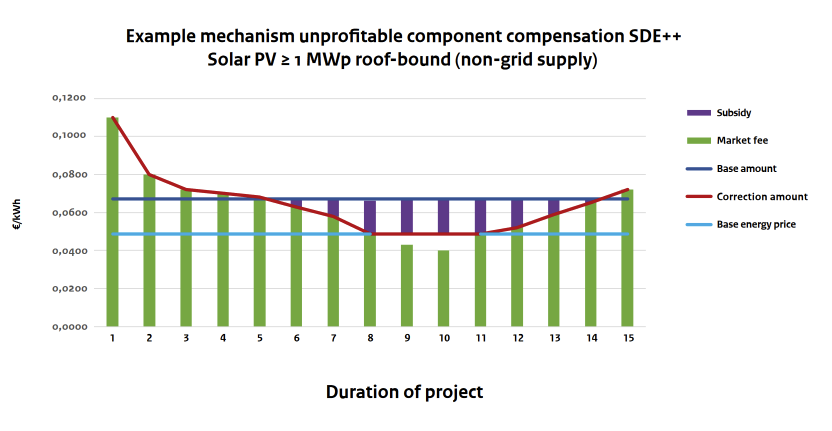

Source: SDE ++ 2023
Stimulation of Sustainable Energy Production
and Climate Transition
Commissioned by the Ministry of Economic Affairs and Climate Policy: https://english.rvo.nl/sites/default/files/2023-09/BrochureSDE2023English.pdf

In the following exercise, we will assume that the market fee is always between the base amount and the base energy price.

## Problem: How to take into account for risk in production?

### Two main revenue systems
#### Linear Revenue

With a linear revenue system, the payoff of a firm with a production of $N$ and  bid $P$ is simply calculated as $$Linear Revenue = N *P$$

    



#### Define Linear revenue

In [7]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os as os


def Revlin(X, P):
    return P * X

#### Step revenue
A step-revenue system is designed to reduce some of the risk linked to the variability of wind speed, and annual production levels.
With a step revenue system, competing firms must include an expected production level, $N_0$,  in their bid. The revenue function is then
flattened between $0.9 \times N_0$ and $1.1 \times N_0$, which eliminates some of the risk about the production level. If the wind speeds are 10\% lower than expected, this revenue system ensures that the firm won't lose much revenue. It is used in auctions in France. 
The step revenue function is:

$$R(N_0, P, N)=
\begin{cases}
P * N & \text{if $N < N_0$ ~(1)} \\
2.8*P*N - 1.53*P*N_0  & \text{if $N \in [0.85*N_0, 0.9*N_0[$ ~(2)} \\
0.1*P*N + 0.9*P*N_0 & \text{if $N \in [0.9*N_0, 1.1*N_0[$ ~(3)} \\
2.8*P*N - 2.07*P*N_0 & \text{if $N \in [1.1*N_0, 1.15*N_0[$ ~(4)} \\
P*N & \text{if $N \geq 1.15 *N_0$ ~(5)}
\end{cases}$$


#### Define Step Revenue Function

In [2]:
def Revpal(N, P, N0):
    RP = np.ones((len(N), 2))
    for i in range(len(N)):
        if N[i] >= 1.15 * N0:
            RP[i, 0] = P * N[i]
            RP[i, 1] = 5
        elif N[i] >= 1.1 * N0:
            RP[i, 0] = 2.8 * P * N[i] - 2.07 * P * N0
            RP[i, 1] = 4
        elif N[i] >= 0.9 * N0:
            RP[i, 0] = 0.1 * P * N[i] + 0.9 * P * N0
            RP[i, 1] = 3
        elif N[i] >= 0.85 * N0:
            RP[i, 0] = 2.8 * P * N[i] - 1.53 * P * N0
            RP[i, 1] = 2
        elif N[i] >= 0.5 * N0:
            RP[i, 0] = P * N[i]
            RP[i, 1] = 1
        else:
            RP[i, 0] = P * N[i]
            RP[i, 1] = 1
    return RP

#### Plot Step revenue function

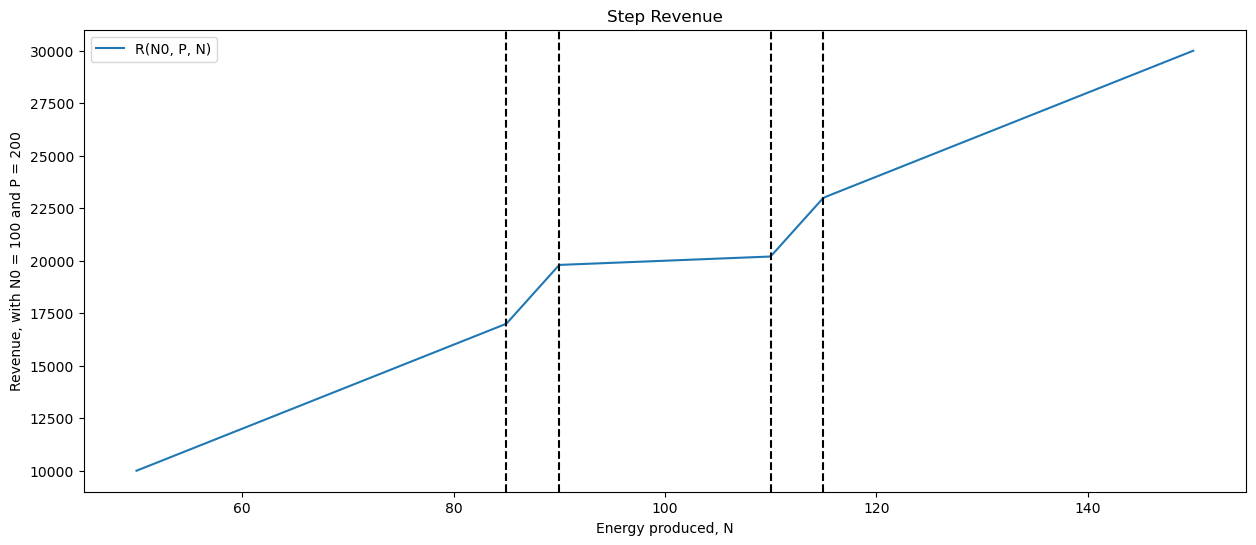

In [3]:
# Define parameters
P = 200
N0 = 100
N = np.linspace(50, 150, 400)

# Calculate RP values
RP = Revpal(N, P, N0)

# Plot the graph
plt.figure(figsize=(15, 6))
plt.plot(N, RP[:, 0], label='R(N0, P, N)')
plt.xlabel('Energy produced, N')
plt.ylabel('Revenue, with N0 = 100 and P = 200')
plt.title('Step Revenue')
zone = [85, 90, 110, 115]
for z in zone:
    plt.axvline(x=z, color='black', linestyle='--')
plt.legend()
plt.show()

### Distribution of Production 

We consider 4 different locations. The wind and production data comes from "Renewable-ninja" https://www.renewables.ninja/.

We perform bootstrap simulations to create a distribution of wind electricity production.  

In [8]:
def process_data(sheet_range):
    path = os.getcwd()+'\\Data\\'
    A = pd.read_excel(path+"Datas_trim.xlsx", usecols='J:M', skiprows=sheet_range, nrows=6).to_numpy()
    n = 6
    Z = np.ones((n, n))
    
    for j in range(n):
        for i in range(n):
            Z[i, j] = A[j, 2] + A[i, 3]
    
    Z = Z.reshape(36, 1)
    Y = np.ones((n, len(Z)))
    
    for j in range(len(Z)):
        for i in range(n):
            Y[i, j] = Z[j] + A[i, 1]
    
    Y = Y.reshape(36 * 6, 1)
    X = np.ones((n, len(Y)))
    
    for j in range(len(Y)):
        for i in range(n):
            X[i, j] = Y[j] + A[i, 0]
    
    return X.reshape(36 * 36, 1)

In [9]:
def plot_production(X, ax):
    ax.hist(X, bins=200, color='b', alpha=1, density=True, label='Distribution of production')
    ax.set_xlabel('Production')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')

In [10]:
X1 = process_data(0)
X2 = process_data(8)
X3 = process_data(16)
X4 = process_data(24)

#### Plots

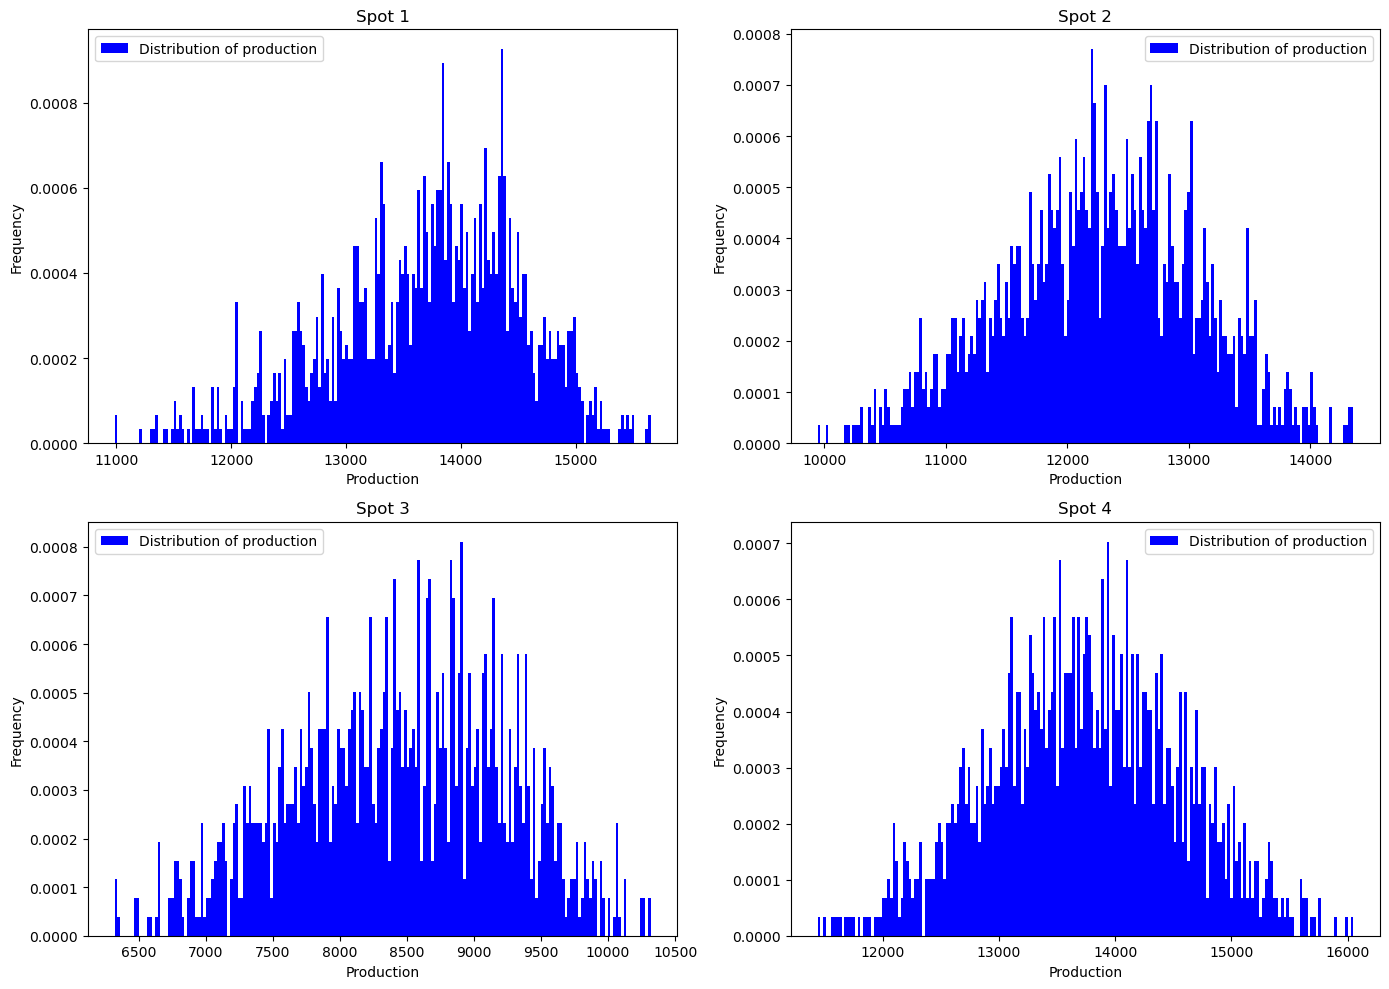

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot each dataset in a subplot
plot_production(X1, axs[0, 0])
axs[0, 0].set_title('Spot 1')

plot_production(X2, axs[0, 1])
axs[0, 1].set_title('Spot 2')

plot_production(X3, axs[1, 0])
axs[1, 0].set_title('Spot 3')

plot_production(X4, axs[1, 1])
axs[1, 1].set_title('Spot 4')

plt.tight_layout()
plt.show()

#### Profits

We can now calculate the profits at each point. 

In [12]:
def profit_and_plot(X, ax, P, Cv, Cf, year):
    N0 = np.mean(X)
    
    # Linear revenue
    Rlin = Revlin(X, P)
    
    # Step revenue
    Rpal = Revpal(X, P, N0)
    
    # Costs : 
    annual_costs =  Cv + Cf / year # Variable annual costs - annualised fixed costs
    
    # Calculate profit (Revenue - costs)
    Profit_pal = Rpal[:, 0] - annual_costs
    Profit_lin = Rlin - annual_costs
    
    # Plot the results
    ax.hist(Profit_pal, bins=200, color='g', alpha=0.5, density=True, label='Step revenue')
    ax.hist(Profit_lin, bins=200, color='r', alpha=0.5, density=True, label='Linear revenue')
    ax.set_xlabel('Profits')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')
    

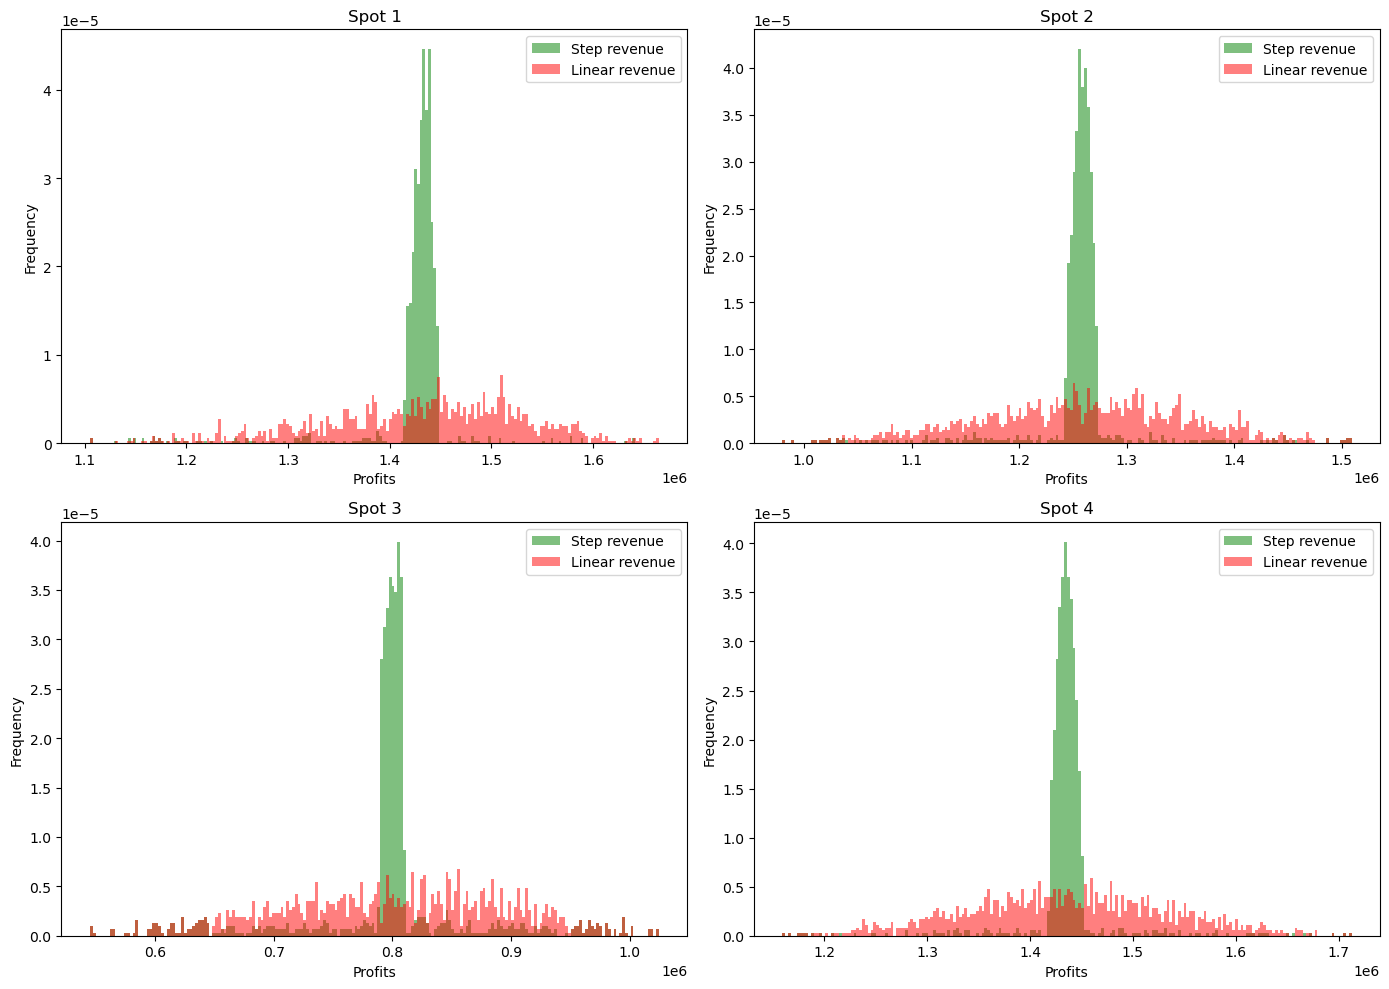

In [13]:
# Parameters

P = 120  # €/MWh
Cv = 60000 # Annual costs
Cf = 4600000 # Fixed Costs
year = 30

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot each dataset in a subplot
profit_and_plot(X1, axs[0, 0], P, Cv, Cf, year)
axs[0, 0].set_title('Spot 1')

profit_and_plot(X2, axs[0, 1], P, Cv, Cf, year)
axs[0, 1].set_title('Spot 2')

profit_and_plot(X3, axs[1, 0], P, Cv, Cf, year)
axs[1, 0].set_title('Spot 3')

profit_and_plot(X4, axs[1, 1], P, Cv, Cf, year)
axs[1, 1].set_title('Spot 4')

plt.tight_layout()
plt.show()

## Question 1

### Describe the distribution of profit with linear revenue and step revenue. 

Answer

## Question 2

### a. Calculate the expected profit with both revenue schemes.

In [14]:
# Code to complete

def profit(X, P, Cv, Cf, year):
    N0 = np.mean(X) # + 0.01 * np.mean(X) Last question: Bonus
    
    # Linear revenue
    Rlin = Revlin(X, P)
    
    # Step revenue
    Rpal = Revpal(X, P, N0)
    
    # Costs : 
    annual_costs =  Cv + Cf / year # Variable annual costs - annualised fixed costs
    
    # Calculate profit (Revenue - costs)
    Profit_pal = Rpal[:, 0] - annual_costs
    Profit_lin = Rlin - annual_costs
    
    # Calculate average profits
    
    expected_pal = np.mean(Profit_pal)
    expected_lin = np.mean(Profit_lin)
    
    return f"Expected revenue step = {expected_pal}, Expected revenue linear = {expected_lin}"

In [15]:
profit(X1, P, Cv, Cf, year), profit(X2, P, Cv, Cf, year), profit(X3, P, Cv, Cf, year), profit(X4, P, Cv, Cf, year)

('Expected revenue step = 1424664.9068697826, Expected revenue linear = 1431361.3612660288',
 'Expected revenue step = 1255987.4722565443, Expected revenue linear = 1258058.6115096444',
 'Expected revenue step = 796370.0329845282, Expected revenue linear = 799537.3574438321',
 'Expected revenue step = 1434324.5436151365, Expected revenue linear = 1434872.9386718518')

### b. Which revenue scheme would be more profitable for the firms?

Answer

### Introducing Risk Aversion

As we have discussed during the Lecture, investors are generally risk-averse. This means that they prefer sure outcomes over risky ones. One way to model this aversion to risk is the Constant Relative Risk Aversion function (CRRA):

$$U(R,\gamma)=\frac{profit^{1-\gamma} - 1}{1-\gamma}$$

The parameter $\gamma$ is called the risk aversion coefficient: the higher the $\gamma$, the more risk-averse the investor.

In [21]:
# Function Definitions

# Utility
def Utility(gamma, Profit):
    Profit = Profit/10**5 # Profit in thousands
    if gamma == 1:
        return np.log(Profit)
    else:
        return (Profit**(1 - gamma)-1) / (1 - gamma)
    
#Expected Utility

def EUtility(gamma, Profit):
    return np.sum(Utility(gamma, Profit)) / len(Profit)

## Question 3

### Plot the distribution of utility with $gamma = 0$ and $gamma = 4$

In [17]:
# To complete
def utility_risk(X, ax, P, Cv, Cf, year, gamma):
    N0 = np.mean(X) # + 0.01 * np.mean(X) Last question: Bonus
    
    # Linear revenue
    Rlin = Revlin(X, P)
    
    # Step revenue
    Rpal = Revpal(X, P, N0)
    
    # Costs : 
    annual_costs =  Cv + Cf / year # Variable annual costs - annualised fixed costs
    
    # Calculate profit (Revenue - costs)
    Profit_pal = Rpal[:, 0] - annual_costs
    Profit_lin = Rlin - annual_costs
    
    # Calculate Utility
    Utility_pal = Utility(gamma, Profit_pal) # ...
    Utility_lin = Utility(gamma, Profit_lin) # ...
    
    # Plot the results
    ax.hist(Utility_pal, bins=200, color='g', alpha=0.5, density=True, label='Step revenue')
    ax.hist(Utility_lin, bins=200, color='r', alpha=0.5, density=True, label='Linear revenue')
    ax.set_xlabel('Utility')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')

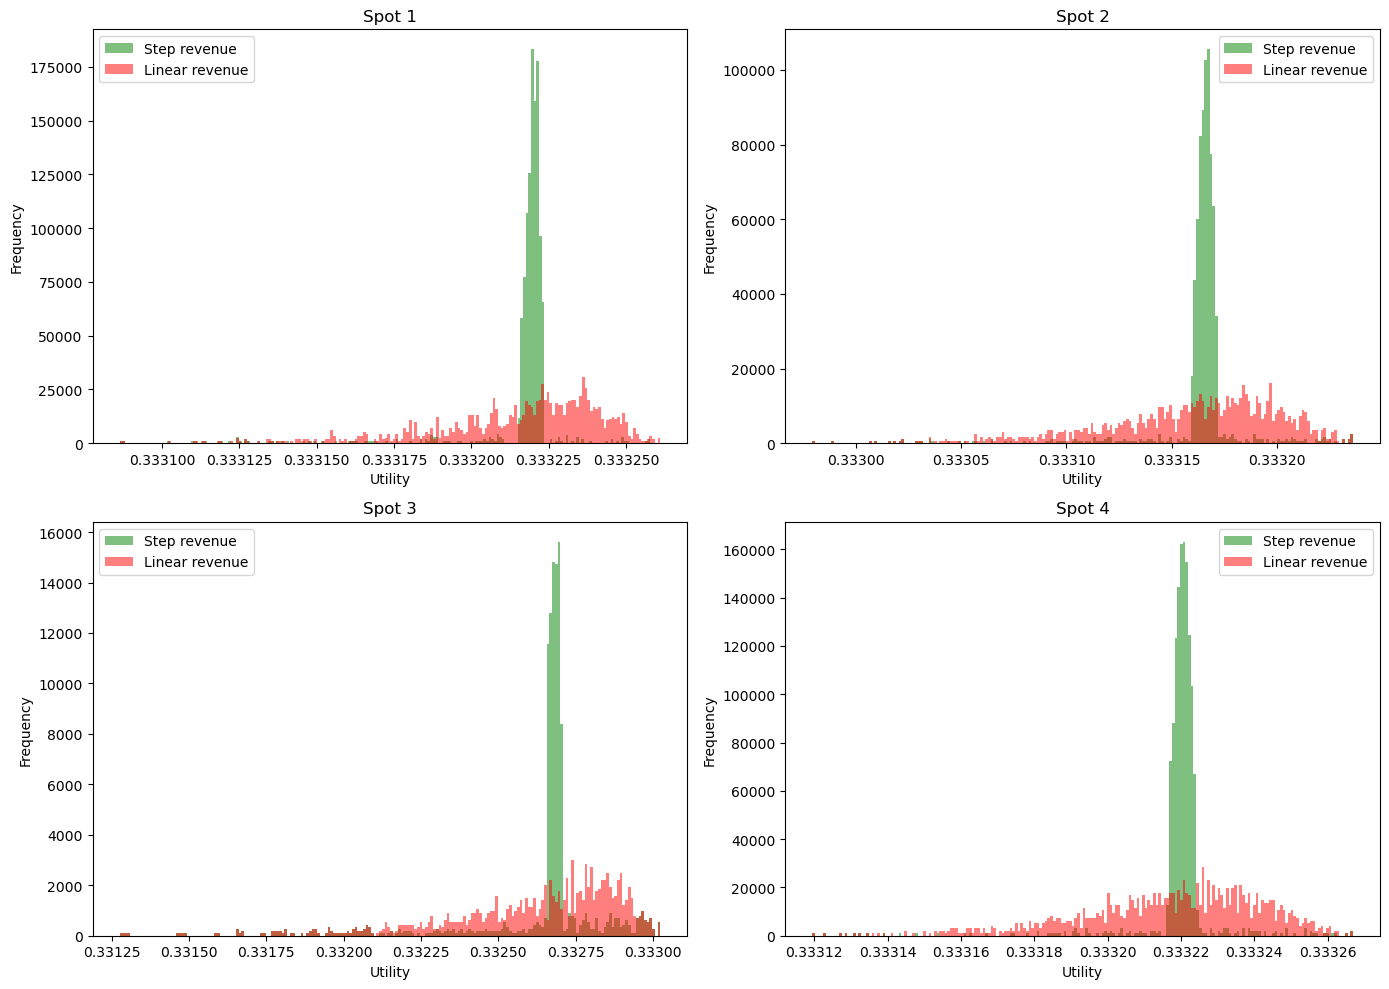

In [22]:
gamma = 4

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot each dataset in a subplot
utility_risk(X1, axs[0, 0], P, Cv, Cf, year, gamma)
axs[0, 0].set_title('Spot 1')

utility_risk(X2, axs[0, 1], P, Cv, Cf, year, gamma)
axs[0, 1].set_title('Spot 2')

utility_risk(X3, axs[1, 0], P, Cv, Cf, year, gamma)
axs[1, 0].set_title('Spot 3')

utility_risk(X4, axs[1, 1], P, Cv, Cf, year, gamma)
axs[1, 1].set_title('Spot 4')

plt.tight_layout()
plt.show()

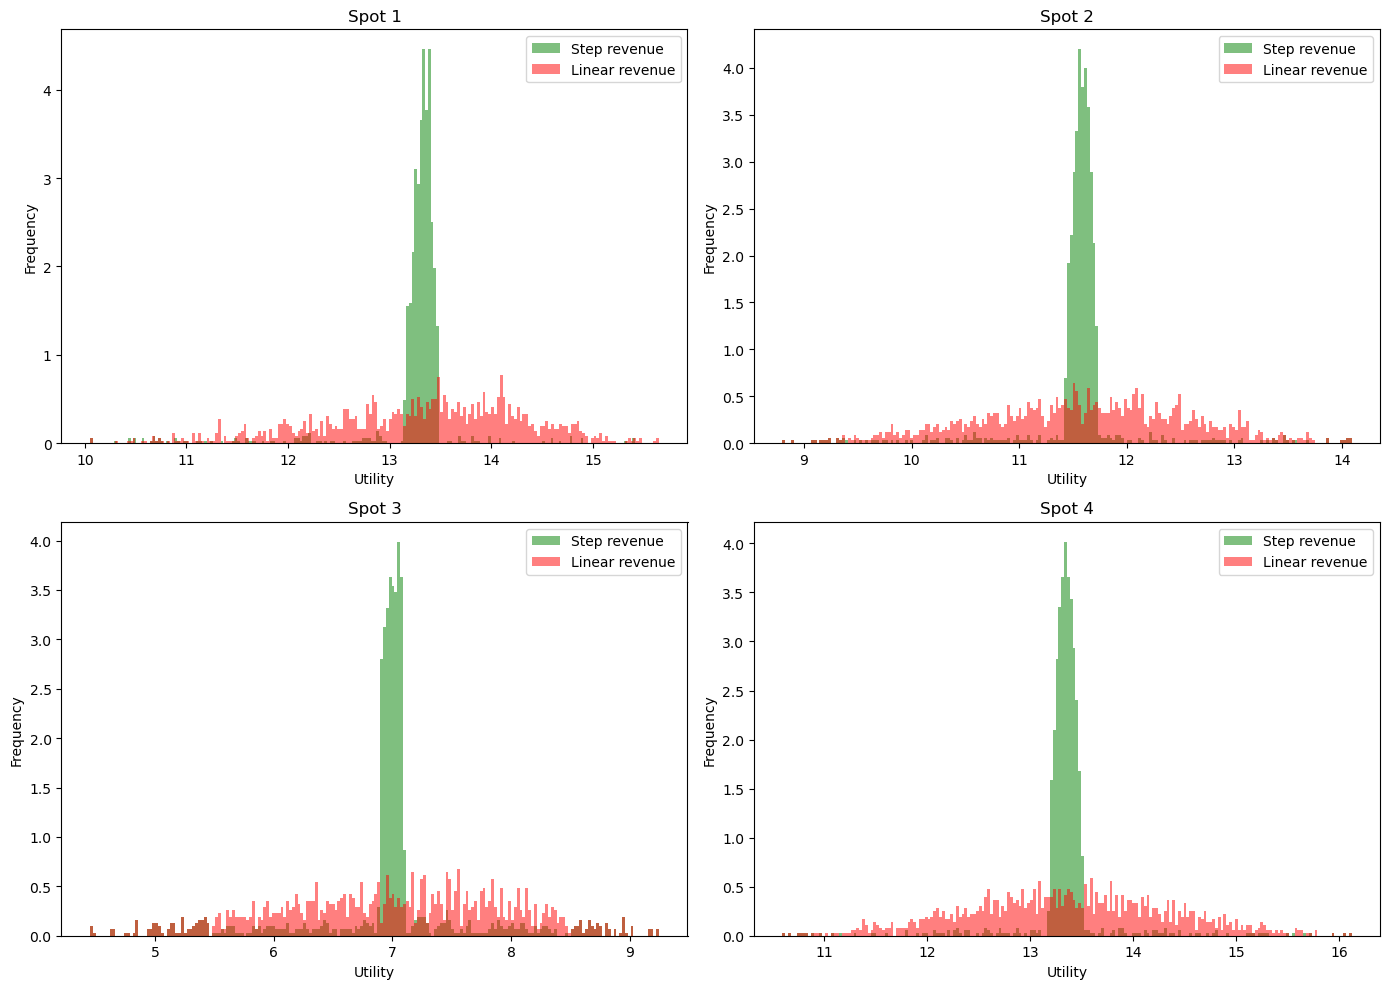

In [23]:
gamma = 0
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot each dataset in a subplot
utility_risk(X1, axs[0, 0], P, Cv, Cf, year, gamma)
axs[0, 0].set_title('Spot 1')

utility_risk(X2, axs[0, 1], P, Cv, Cf, year, gamma)
axs[0, 1].set_title('Spot 2')

utility_risk(X3, axs[1, 0], P, Cv, Cf, year, gamma)
axs[1, 0].set_title('Spot 3')

utility_risk(X4, axs[1, 1], P, Cv, Cf, year, gamma)
axs[1, 1].set_title('Spot 4')

plt.tight_layout()
plt.show()

## Question 4

### a. Calculate the expected utility for both revenue schemes, with gamma = 0 and gamma = 4.

In [24]:
## To complete

def Eutility_risk(X, P, Cv, Cf, year, gamma):
    N0 = np.mean(X) # + 0.01 * np.mean(X) Last question: Bonus
    
    # Linear revenue
    Rlin = Revlin(X, P)
    
    # Step revenue
    Rpal = Revpal(X, P, N0)
    
    # Costs : 
    annual_costs =  Cv + Cf / year # Variable annual costs - annualised fixed costs
    
    # Calculate profit (Revenue - costs)
    Profit_pal = Rpal[:, 0] - annual_costs
    Profit_lin = Rlin - annual_costs
    
    # Calculate Utility
    EUtility_pal = EUtility(gamma, Profit_pal) 
    EUtility_lin = EUtility(gamma, Profit_lin) 
    
    return f"Expected utility step = {EUtility_pal}, Expected utility linear = {EUtility_lin}"

In [25]:
gamma = 4
Eutility_risk(X1, P, Cv, Cf, year, gamma), Eutility_risk(X2, P, Cv, Cf, year, gamma), Eutility_risk(X3, P, Cv, Cf, year, gamma), Eutility_risk(X4, P, Cv, Cf, year, gamma)

('Expected utility step = 0.3332170749171678, Expected utility linear = 0.3332160764829067',
 'Expected utility step = 0.3331633992585408, Expected utility linear = 0.33315969807522683',
 'Expected utility step = 0.33263528959349165, Expected utility linear = 0.33261806477451356',
 'Expected utility step = 0.33321975240154, Expected utility linear = 0.33321720078686895')

In [26]:
gamma = 0
Eutility_risk(X1, P, Cv, Cf, year, gamma), Eutility_risk(X2, P, Cv, Cf, year, gamma), Eutility_risk(X3, P, Cv, Cf, year, gamma), Eutility_risk(X4, P, Cv, Cf, year, gamma)

('Expected utility step = 13.246649068697828, Expected utility linear = 13.31361361266029',
 'Expected utility step = 11.559874722565441, Expected utility linear = 11.580586115096445',
 'Expected utility step = 6.963700329845283, Expected utility linear = 6.9953735744383225',
 'Expected utility step = 13.343245436151363, Expected utility linear = 13.348729386718517')

### b. Which revenue scheme would be preferred by a risk-neutral firm (gamma = 0)? Which revenue scheme would be preferred by a risk-averse firm (gamma = 2)?

Answer

## Question 5

### a. Discuss how can policy-makers address the production risks in renewable energy investments. 

Answer

### b. What are the drawbacks of reducing the risks faced by investors?

Answer